In [11]:
import sys
import os
import numpy as np
import dill
from cycler import cycler
%matplotlib inline
import matplotlib.pyplot as plt
root_dir = os.path.join(os.getcwd(), '..')
sys.path.append(root_dir)
from src.utilities.AttrDict import AttrDict
GEOMETRY = AttrDict()
GATE = AttrDict()
from src.configuration import t#, dt, n_x, n_z, rho_s, dx, dz
# from scipy.interpolate import interp1d, InterpolatedUnivariateSpline
from src.utilities.nearest import nearest
from src.initialisation.initialise_main import initialisation
from src.pressure import pressure
from src.stress import stress_time

# Plotting options
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Helvetica'] + plt.rcParams['font.serif']
params = {'legend.fontsize': 'large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'large',
         'axes.titlesize':'large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large'}
plt.rcParams.update(params)
plt.rcParams['axes.prop_cycle'] = cycler(color=['#000000'])

Specify the name of the load case and the amount of modes to consider, and initialize the model.
For every new gate design the entire notebook should be reset and re-initialized.

In [2]:
GATE.case   = 'Gate1_test'
GATE.n_modes= 16
GATE.Ly     = 1 # Overhang length
GATE.zeta   = 0.02 # Damping
GATE.cdamp  = 0 # Distributed damping
GATE.HEIGHT = 7.5
GATE.WIDTH  = 10
## Heights of horizontal stiffeners
GEOMETRY.Height  = 2.55
GEOMETRY.Height2 = 5.0
GEOMETRY.Height3 = GATE.HEIGHT
## X-coordinates of vertical stiffeners
GEOMETRY.Width  = 2.5
GEOMETRY.Width2 = 5
GEOMETRY.Width3 = 7.45
GEOMETRY.Width4 = GATE.WIDTH
## Stiffener depths
GEOMETRY.LengthHorRibs  = 0.71
GEOMETRY.LengthVertRibs = 0.71
## Supports (Left-Bottom-Right-Top)
GEOMETRY.Stiffness  = 3e11
GEOMETRY.Stiffness2 = 0
GEOMETRY.Stiffness3 = 3e11
GEOMETRY.Stiffness4 = 0
## Element thicknesses
GEOMETRY.Platethickness    = 0.05
GEOMETRY.RibThicknessHor   = 0.1
GEOMETRY.RibThicknessHor2  = 0.1
GEOMETRY.RibThicknessHor3  = 0.1
GEOMETRY.RibThicknessHor4  = 0.1
GEOMETRY.RibThicknessVert  = 0.1
GEOMETRY.RibThicknessVert2 = 0.1
GEOMETRY.RibThicknessVert3 = 0.1
GEOMETRY.RibThicknessVert4 = 0.1
GEOMETRY.RibThicknessVert5 = 0.1
GATE.GEOMETRY = GEOMETRY

GATE = initialisation(GATE, overwrite=False)

Loading existing modes...
Loaded existing frequency response function(s) and gate properties for case Gate1_test.


In [4]:
# # Modules
# import numpy as np
# import pandas as pd
# %matplotlib inline
# import matplotlib.pyplot as plt
# import matplotlib.colors as colors
# from cycler import cycler
# import matplotlib
# from mpl_toolkits.mplot3d import Axes3D
# from mpl_toolkits.mplot3d.art3d import Poly3DCollection
# import cloudpickle
# import os
# import sys
# import importlib
# root_dir = os.path.join(os.getcwd(), '..')
# sys.path.append(root_dir)

# ## Configure system properties
# import src
# from src.utilities import load_mat, PlotText

# ## Load custom scripts for pressure and stress computation
# from src.full_gate_fatigue import fatigue_gate,\
# modalstresscontribution, modalfatiguecontribution, plot_fatigue_gate
# from src.utilities.nearest import nearest
# from src.lifetime import generate_fatigue, simulations, compare_simulations

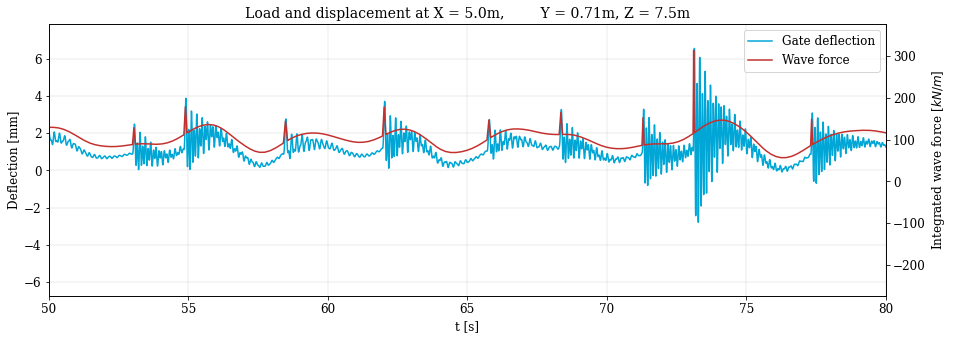

In [4]:
from src.disp import disp_time
coords = nearest(5, 1, 7.5)

freqs, pqs_f, impact_force_t, Hs, Tp = pressure(20, 7.5)
res = disp_time(freqs, pqs_f, impact_force_t, coords, plot=True, plotrange=[50,80])

## Load case definition

First the raw data is read from the specified text files and formatted in a DataFrame. The formatted data is then stored in the 02_preprocessing folder.

Data stored in ../data/02_preprocessing/data_1971.cp.pkl


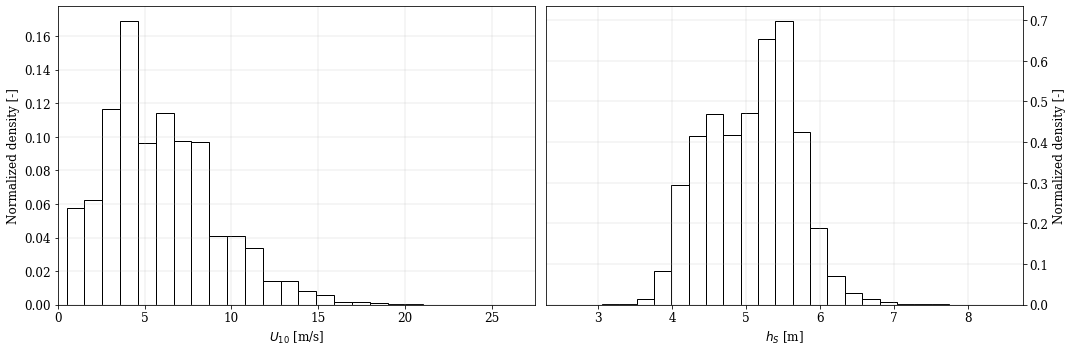

In [5]:
from src.loadcases import import_raw_data, create_pdf, binning, binfilter
fig, raw_data = import_raw_data(windfile='KNMI_20201124_hourly.txt', waterfile='20201105_007.csv', bins=25)
fig

Next, the data is pre-processed and transformed into two probability distributions which also account for climate change.

Pearsons correlation: 0.158
Integral of convoluted pdf: 1.001


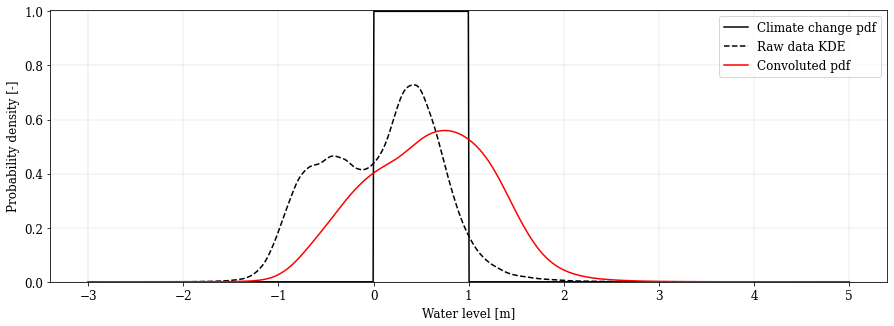

In [6]:
fig, dists = create_pdf(raw_data, rise=1, n_h=1000, n_u=1e4, h_range=[2,10])
fig

The probability distributions are then integrated into discrete sections, whose expected values will represent the properties of the discrete load cases. The probability of occurrence is found by integrating the probability density over the area of the segment.

80 h_S-bins by 56 u-bins


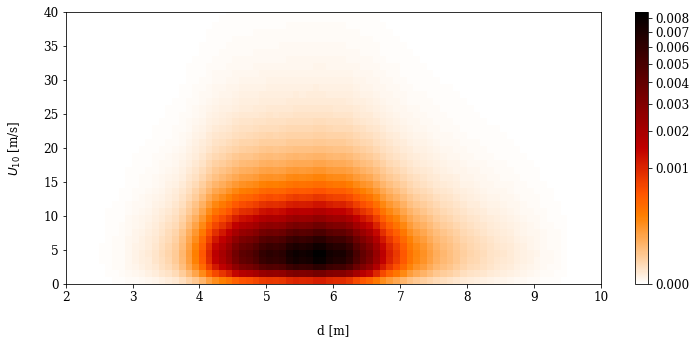

In [7]:
fig1, u_bins, h_bins, cases = binning(dists, h_res=0.1, u_res=1)
fig1

The load cases are then filtered based on their probability of occurrence and their intensity.

Starting with 4480 cases
Filtering cases with probability less than 1/10,000 years...
4480 cases left after frequency filtering
Filtering cases with h_S+2*Hm0 < h_G...
1483 cases left after Hm0 filtering
66% of bins filtered out.


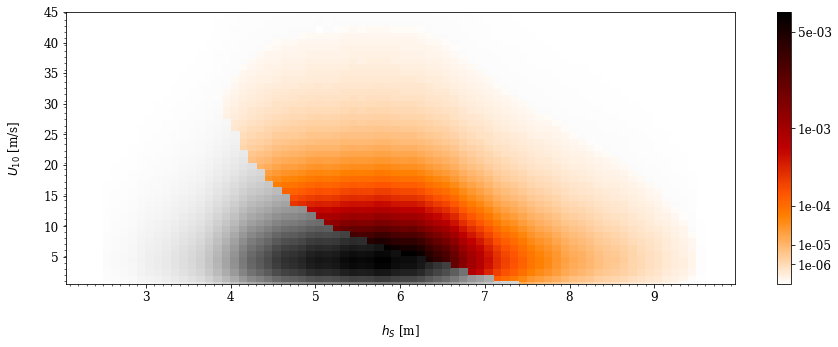

In [8]:
fig2, filtcases = binfilter(cases, GATE, freqfilter=True, intensityfilter=True)
fig2

## Analyse fatigue over gate surface

In [4]:
from src.full_gate_fatigue import fatigue_gate, plot_fatigue_gate, modalstresscontribution, modalfatiguecontribution

u_wind = 20
h_sea = 7
ID=GATE.case

In [6]:
D, modeshare = fatigue_gate(u_wind, h_sea, cat=100, ID=GATE.case)

Maximum fatigue is 0.00036 and occurs at: [5.   0.71 7.5 ]
Maximum fatigue in Gate1_test: 0.00036
Maximum fatigue in Gate1_1mode: 8e-05


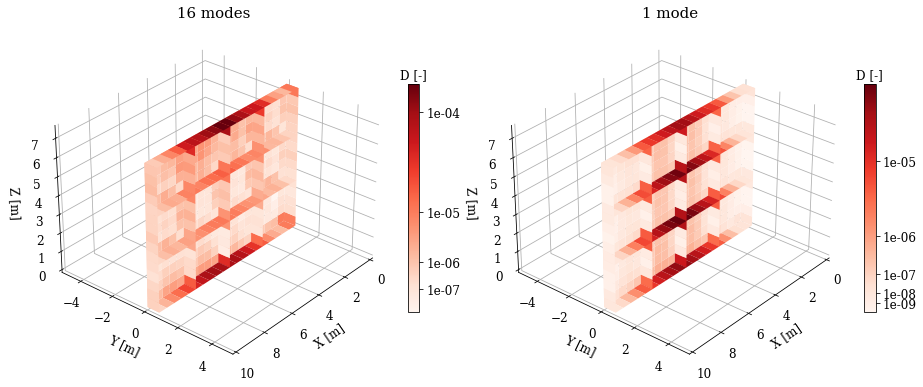

In [8]:
with open('../data/08_analysis/full_gate_fatigue/gatefatigue_('+str(u_wind)+','+str(h_sea)+'_'+str(ID)+').cp.pkl', 'rb') as f:
    damage_gate, modeshare = dill.load(f)
max_coords = GATE.coords[np.argmax(damage_gate)]
print("Maximum fatigue is %s and occurs at: %s"%(round(np.max(damage_gate),5), max_coords))
plot_fatigue_gate(['Gate1_test', 'Gate1_1mode'], ['16 modes', '1 mode'], u_wind, h_sea)

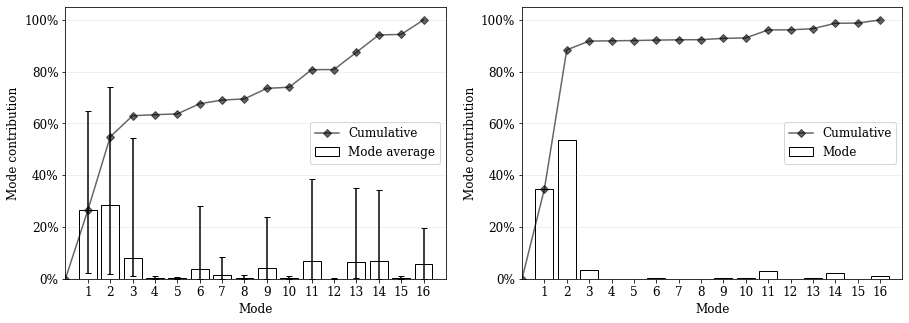

In [9]:
modalstresscontribution(modeshare, max_coords)

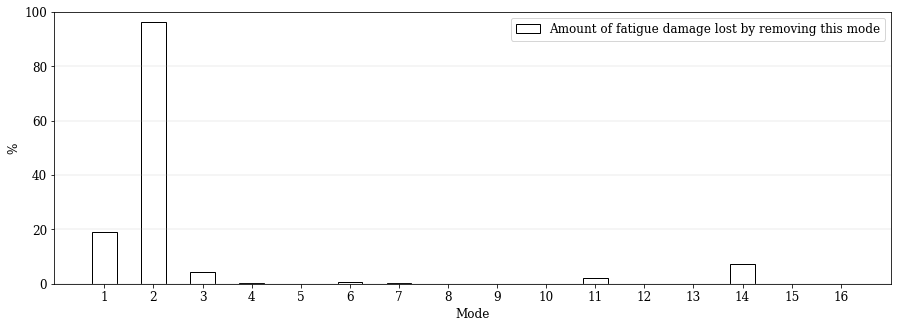

In [11]:
fig, shares = modalfatiguecontribution(u_wind, h_sea, max_coords, cat=100, save=False)
fig

## Full lifetime fatigue analysis

First, define the coordinates to evaluate and the name under which the results should be stored.

In [6]:
coords = nearest(5,1,7.5)
version = GATE.case
print(coords, version)

(5.0, 0.71, 7.5) Gate1_test


The following function evaluates the fatigue for all previously derived load cases at the coordinate specified above, and performs a probabilistic fatigue lifetime simulation (can take an hour for new cases). If the version name has already been used before, the existing data will be loaded instead.

In [15]:
from src.lifetime import generate_fatigue, simulations

damage_list = generate_fatigue(coords, version, N=1e6)
fig, D_expected, totals, [maxes,means,mins] = simulations(1000, version, average_only=False)

Analyzing coordinate (5.0, 0.71, 7.5)
Using existing runs from ../data/07_fatigue/Gate1_test.cp.pkl
N load cases already exist.
Running 1000 Monte Carlo simulations...
